In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np

from scipy.signal import convolve2d
from scipy.signal.windows import gaussian

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from analysis.map import Map
from analysis.persistence_diagram import PersistenceDiagram


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:

data_range = [-0.05, 0.05]
rng = np.random.default_rng(seed=354354)

In [37]:
def convolve(map):
	# Scale parameter of the Gaussian
	pixel_scale = np.abs(data_range[1] - data_range[0]) / map.shape[0]
	# Determine the scale parameter (std, sigma) of the Gaussian kernel
	# Set to 1/25th of the range, similar value as Heydenreich+2022
	scale_parameter = 1. / 25. * np.abs(data_range[1] - data_range[0])

	sigma_in_pixel = scale_parameter / pixel_scale
	print(f'sigma_in_pixel={sigma_in_pixel}')
	gaussian_size_in_pixel = sigma_in_pixel * 2 * 3  # Two times because symmetric Gaussian with both sides

	gaussian_kernel1d = gaussian(int(np.round(gaussian_size_in_pixel)), std=sigma_in_pixel)
	gaussian_kernel = np.outer(gaussian_kernel1d, gaussian_kernel1d)

	return convolve2d(map, gaussian_kernel, mode='same')

def fix_range(map, new_range=None):
	# TODO: what if I want a different range? or increase maxima?
	if new_range is None:
		new_range = data_range
	
	scale_param = np.abs(new_range[0] - new_range[1]) / np.abs(map.max() - map.min())
	return map * scale_param + np.mean(new_range)

def apply_noise(map, scale=0.01):
	return map + rng.normal(loc=0., scale=scale, size=map.shape)

def map_pipeline(map):
	return fix_range(
		convolve(
			apply_noise(
				map
			)
		)
	)

def plot_result(convolved_map):
	fig, ax = plt.subplots()
	imax = ax.imshow(convolved_map)
	fig.colorbar(imax)
	return fig, ax

[[-0.02113692 -0.00443848 -0.00960072]
 [-0.02142695  0.05246045  0.01152686]
 [ 0.02032757  0.00361362 -0.05131693]]


(<Figure size 640x480 with 2 Axes>, <Axes: >)

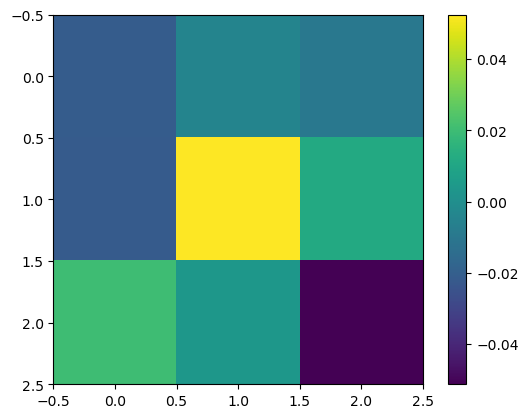

In [15]:
dummy_map = np.array([
	[0, 0, 0],
	[0, 1, 0],
	[0, 0, -1]
])

result_map = map_pipeline(dummy_map)
print(result_map)

plot_result(result_map)


sigma_in_pixel=10.0


(<Figure size 640x480 with 2 Axes>, <Axes: >)

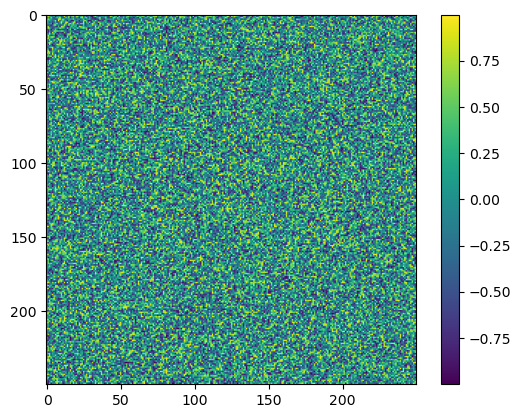

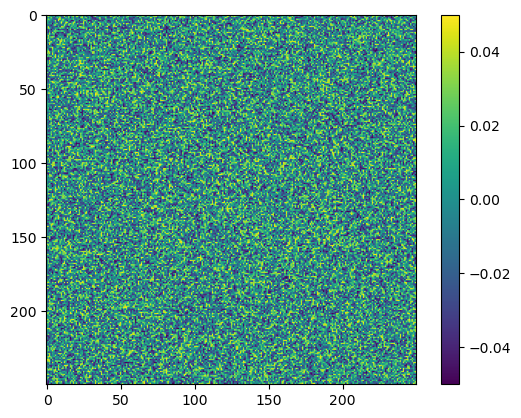

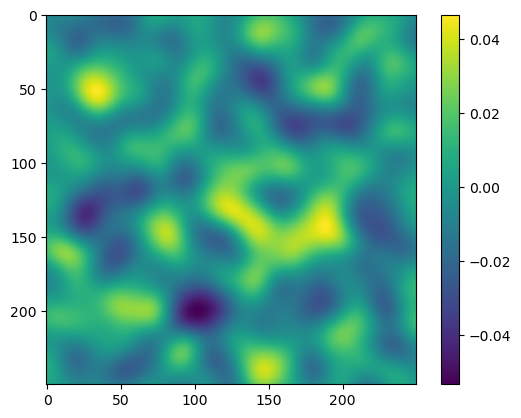

In [40]:
big_map = rng.uniform(low=-1, high=1, size=(250, 250))
plot_result(big_map)
plot_result(fix_range(big_map))
result_map = map_pipeline(big_map)
plot_result(result_map)



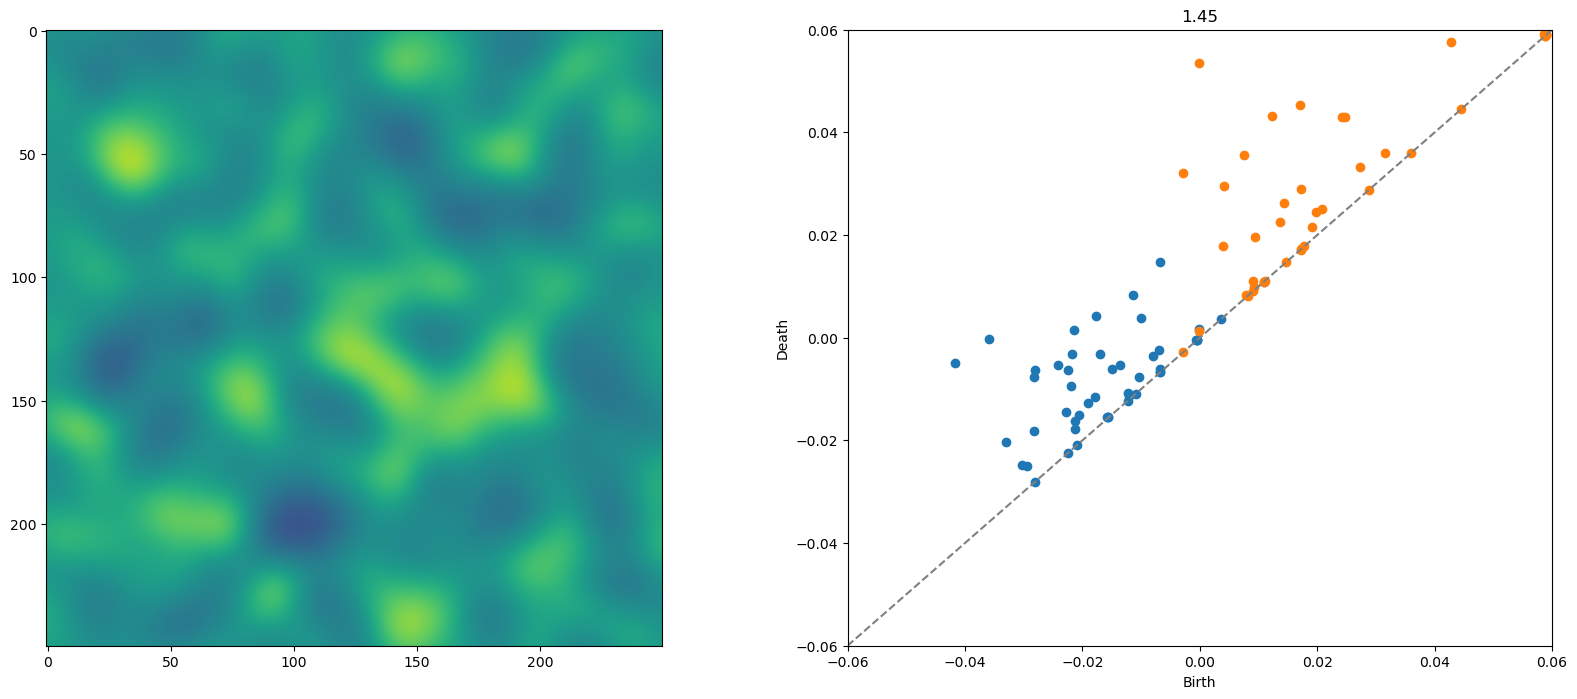

In [42]:
def perdi_plot(map, cosm):
	m = Map(map=map)
	m.get_persistence()
	perdi = PersistenceDiagram([m], cosmology='dummy')
	perdi.plot(close=False, plot_args={'s': 10})

def create_animation(map):
	m = Map(map=map)
	m.get_persistence()
	# Figure and Axes which will contain animation
	fig, axes = plt.subplots(ncols=2, figsize=(20, 8))

	ax = axes[1]
	imax = axes[0]

	# Setup layout and diagonal line
	ax.set_xlabel('Birth')
	ax.set_ylabel('Death')
	lim = 0.06
	ax.set_ylim(ymin=-lim, ymax=lim)
	ax.set_xlim(xmin=-lim, xmax=lim)
	eq_line = np.linspace(-lim, lim, 2)
	ax.plot(eq_line, eq_line, linestyle='--', color='grey')

	# Calculate imshow min and max value to keep range the same
	vmin = map.min() * 2.
	vmax = map.max() * 2.

	# Elements that will be updated each frame
	scat_dim0 = ax.scatter(m.dimension_pairs[0][:, 0], m.dimension_pairs[0][:, 1])
	scat_dim1 = ax.scatter(m.dimension_pairs[1][:, 0], m.dimension_pairs[1][:, 1])
	imshow = imax.imshow(map, vmin=vmin, vmax=vmax)
	ax.set_title(f'{1:.2f}')

	# Iterator of multiplication factors
	factor_iter = np.arange(1., 1.5, .05)

	def update(frame):
		factor = factor_iter[frame]
		# Increase maxima
		new_map = np.where(map > 0., map * factor, map)
		# Normalize?
		# new_map = new_map * np.sum(map) / np.sum(new_map)

		# Calculate new persistence
		m = Map(map=new_map)
		m.get_persistence()

		# Update elements
		scat_dim0.set_offsets(m.dimension_pairs[0])
		scat_dim1.set_offsets(m.dimension_pairs[1])
		imshow.set(data=new_map)
		ax.set_title(f'{factor:.2f}')
	
	anim = animation.FuncAnimation(fig=fig, func=update, frames=len(factor_iter), interval=500)
	anim.save(filename='plots/map_increase.gif', writer='pillow', dpi=100)
	anim.save(filename='plots/map_increase.mp4', writer='ffmpeg', dpi=100)

create_animation(result_map)